YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0849 - val_loss: 0.0431
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031 - val_loss: 0.0071
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0

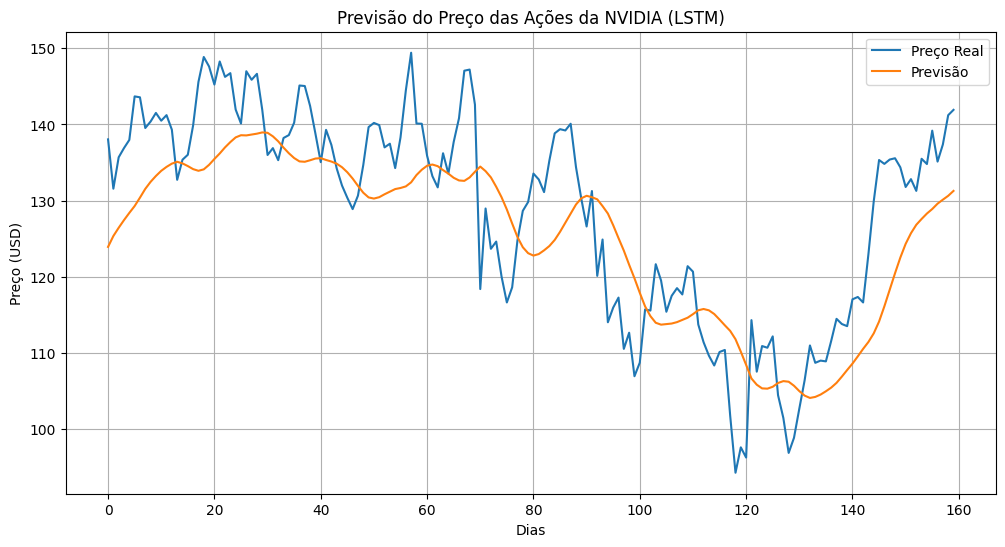

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime

# === 1. Coleta dos dados ===
ticker = 'NVDA'
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']]
df.dropna(inplace=True)

# === 2. Normalização dos dados ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# === 3. Função para criar janelas temporais ===
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# === 4. Divisão dos dados ===
window_size = 60
X, y = create_dataset(scaled_data, window_size)

split = int(len(X) * 0.8)  # 80% treino, 20% validação
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# === 5. Construção do modelo LSTM ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# === 6. Treinamento ===
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# === 7. Previsões ===
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# === 8. Avaliação ===
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = mean_absolute_percentage_error(y_test_actual, predictions)

print(f"\nAvaliação do modelo:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape*100:.2f}%")

# === 9. Plot ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Preço Real')
plt.plot(predictions, label='Previsão')
plt.title('Previsão do Preço das Ações da NVIDIA (LSTM)')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()
